In [18]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os

import numpy as np
import sep
import matplotlib.pyplot as plt
%matplotlib auto

from astropy.io import fits

import gphelper as gp
import ImageTools as it
import DataTools as dt

Using matplotlib backend: Qt5Agg


In [2]:
def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)

    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

In [53]:
def convergence_update(re, is_converged, int_at_re, int_at_limit, rs, convergence_tracking):
    tolerance = 1e-3
    
    ratio = (int_at_re/int_at_limit-0.5)
    
    if (ratio > tolerance):
        print('Trying to shrink from min')
        re = rs[np.nonzero(rs==re)[0][0]-1]
    elif (ratio < -tolerance):
        re = rs[np.nonzero(rs==re)[0][0]+1]
    else:
        is_converged = True
        convergence_tracking['converged'].append(re)
        
    #print(f'New re:{re} from ratio:{int_at_re}/{int_at_limit}-0.5={ratio}')
        
    return re, is_converged

def check_stop_condition(count, max_attempts, re, rs, fs, convergence_tracking):
    stop = False
    
    int_limit = 0
    # we keep bouncing between values take the closest one
    if count==max_attempts:
        stop = True

        int_limit = closest_r(rs, 5*re)
        re_idx = ((np.cumsum(fs[rs<int_limit])/fs[rs<int_limit].sum())-0.5).argmin()
        re = rs[re_idx]
        convergence_tracking['max_attempts'].append(re)
    
    # the source has outgrown our image
    elif 5*re >= 42:
        stop = True
        
        int_limit = closest_r(rs, 42)
        re_idx = np.square((np.cumsum(fs[rs<int_limit])/fs[rs<int_limit].sum())-0.5).argmin()
        re = rs[re_idx]
        convergence_tracking['overgrown'].append(re)
        
        
        
        
    return re, stop, int_limit

def segmap_too_small(src_map):
    area = src_map.sum()
    r = np.sqrt(area/np.pi)
    return r<=15

def closest_r(rs, r):
    r_idx = np.square(rs-r).argmin()
    return rs[r_idx]

def in_segmap_integration(img, src_map):
    rs = rs[src_map].flatten()
    fs = img[src_map].flatten()

    sorted_rs = np.argsort(rs)
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    fs[fs<0] = 0

    fs_int = np.cumsum(fs)

    re_idx = np.argmin(np.square(fs_int/fs.sum()-0.5))
    re = rs[re_idx]
    ie = fs[re_idx]

    fs /= ie
    rs /= re

    fs_int = np.cumsum(fs) / fs.sum()
    
    return rs, fs_int, re

    
    
convergence_tracking = {a:[] for a in ['converged', 'too_small', 'overgrown', 'max_attempts']}
spheroids = get_random_spheroids(num=100)
found_res, rs_re, fs_ie = [], [], []

for img, segmap, img_id in spheroids:
    src_map = segmap==img_id
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=src_map,bw=10,bh=10)
    img_sub = make_nonnegative(img-bkg)

    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(cx-xs) + np.square(cy-ys))
    
    if segmap_too_small(src_map):
        convergence_tracking['too_small'].append(re)
        rs, fs_int, re = in_segmap_integration(img_sub, src_map)
    else:
        # find using iterative method
        rs = rs.flatten()
        fs = img_sub.flatten()

        sorted_rs = np.argsort(rs)
        rs = rs[sorted_rs]
        fs = fs[sorted_rs]

        fs_int = np.cumsum(fs) 

        re = rs.min()#closest_r(rs, 0.05 * rs.max())
        is_converged = False
        max_attempts = 1000
        count = 0

        while not is_converged:
            int_limit = closest_r(rs, 5*re)
            int_at_re = fs_int[rs==re]
            int_at_limit = fs_int[rs==int_limit]
            
            
            
            re, is_converged = convergence_update(re, 
                                                  is_converged,
                                                  int_at_re,
                                                  int_at_limit,
                                                  rs, 
                                                  convergence_tracking)
            #re = closest_r(rs, re)

            if not is_converged:
                re, is_converged, int_limit = check_stop_condition(count, 
                                                                   max_attempts, 
                                                                   re,
                                                                   rs,
                                                                   fs,
                                                                   convergence_tracking)
            print(re)
            count += 1
            
        ie = fs[rs==re].mean()
        
        fs = fs[rs<=int_limit]
        rs = rs[rs<=int_limit]
        
        rs /= re
        fs /= ie
        
        fs_int = np.cumsum(fs) / fs.sum()
        #rs = rs[rs<=5]
        
    rs_re.append(rs)
    fs_ie.append(fs_int)
        
    found_res.append(re)
        
    if len(spheroids)<5:
        plt.figure()
        plt.title(img_id)
        plt.plot(rs, fs_int)
        plt.vlines([1], fs_int.min(), 1)
        plt.hlines([0.5], 0, rs.max())
                   
        plt.show()

UnboundLocalError: local variable 'rs' referenced before assignment

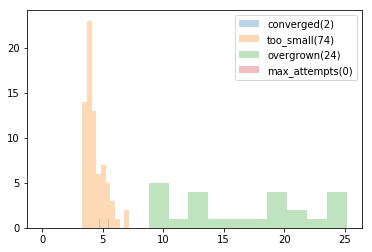

In [51]:
for k in convergence_tracking.keys():
    plt.hist(convergence_tracking[k], alpha=0.3, label=f'{k}({len(convergence_tracking[k])})')

plt.legend()
plt.show()


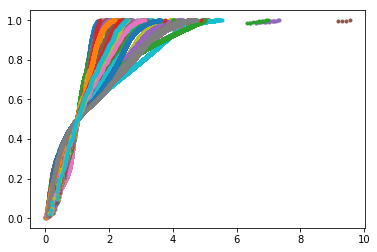

In [6]:
for r, f in zip(rs_re, fs_ie):
    plt.plot(r, f, '.')

plt.show()